<a href="https://colab.research.google.com/github/MASAYA-KINOSHITA/first-Repository/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

import warnings
warnings.simplefilter('ignore', UserWarning)
import gc
gc.enable()

import time
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(0)
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import TimeSeriesSplit

!pip -q install optuna
import optuna.integration.lightgbm as optuna_lgb
import lightgbm as lgb

In [2]:
#ラベルエンコーディング関数の定義
def get_label_encoding(df , cols):
    """label_encoding
    """
    for col in cols:
        df[col].fillna("missing", inplace=True)
        le = LabelEncoder()
        le = le.fit(df[col])
        df["LE=" + col] = le.transform(df[col])
            
    return df

In [3]:
train_original = pd.read_csv('/content/drive/MyDrive/Nishika ソフトウェアの異常検知/train.zip (Unzipped Files)/train.csv')

In [4]:
#コピーを作成
train_df = train_original.copy()
#目的変数の取り出し
target = train_df['Anomaly']
train_df = train_df.drop('Anomaly',axis=1)

In [5]:
# ラベルエンコーディング
cat_cols = ["host", "process"]
train_df = get_label_encoding(train_df, cat_cols)
# 不要なカラムの削除
train_df = train_df.drop(["timestamp", "host", "process"], axis=1)

In [6]:
#相互相関係数0.95以上の特徴量を削除
threshold = 0.95
feat_corr = set()
corr_matrix = train_df.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feat_name = corr_matrix.columns[i]
            feat_corr.add(feat_name)

print('削除された特徴量',len(set(feat_corr)))
train_df.drop(labels=feat_corr, axis='columns', inplace=True)
print('残った特徴量',len(train_df.columns))

削除された特徴量 48
残った特徴量 119


In [7]:
#特徴量重要度を取得する関数を定義
def get_feature_importances(train, target, shuffle, seed=0):

    # 必要なら目的変数をシャッフル
    y = target.copy()
    if shuffle:
        y = target.copy().sample(frac=1.0)

    # LightGBMで訓練
    dtrain = lgb.Dataset(train, y, free_raw_data=False, silent=True)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 128,
        'learning_rate': 0.01,
        'num_iterations':100,
        'feature_fraction': 0.38,
        'bagging_fraction': 0.68,
        'bagging_freq': 5,
        'verbose': 0
    }
    clf = lgb.train(params=params, train_set=dtrain, num_boost_round=200)

    # 特徴量の重要度を取得
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train)
    imp_df["importance"] = clf.feature_importance(importance_type='gain')

    return imp_df

In [8]:
#null_importanceを取得
null_imp_df = pd.DataFrame()
nb_runs = 80
start = time.time()
for i in range(nb_runs):
    imp_df = get_feature_importances(train = train_df, target = target, shuffle=True)
    imp_df['run'] = i + 1 
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)

#実際の特徴量重要度を取得
actual_imp_df = get_feature_importances(train = train_df,target = target, shuffle=False)

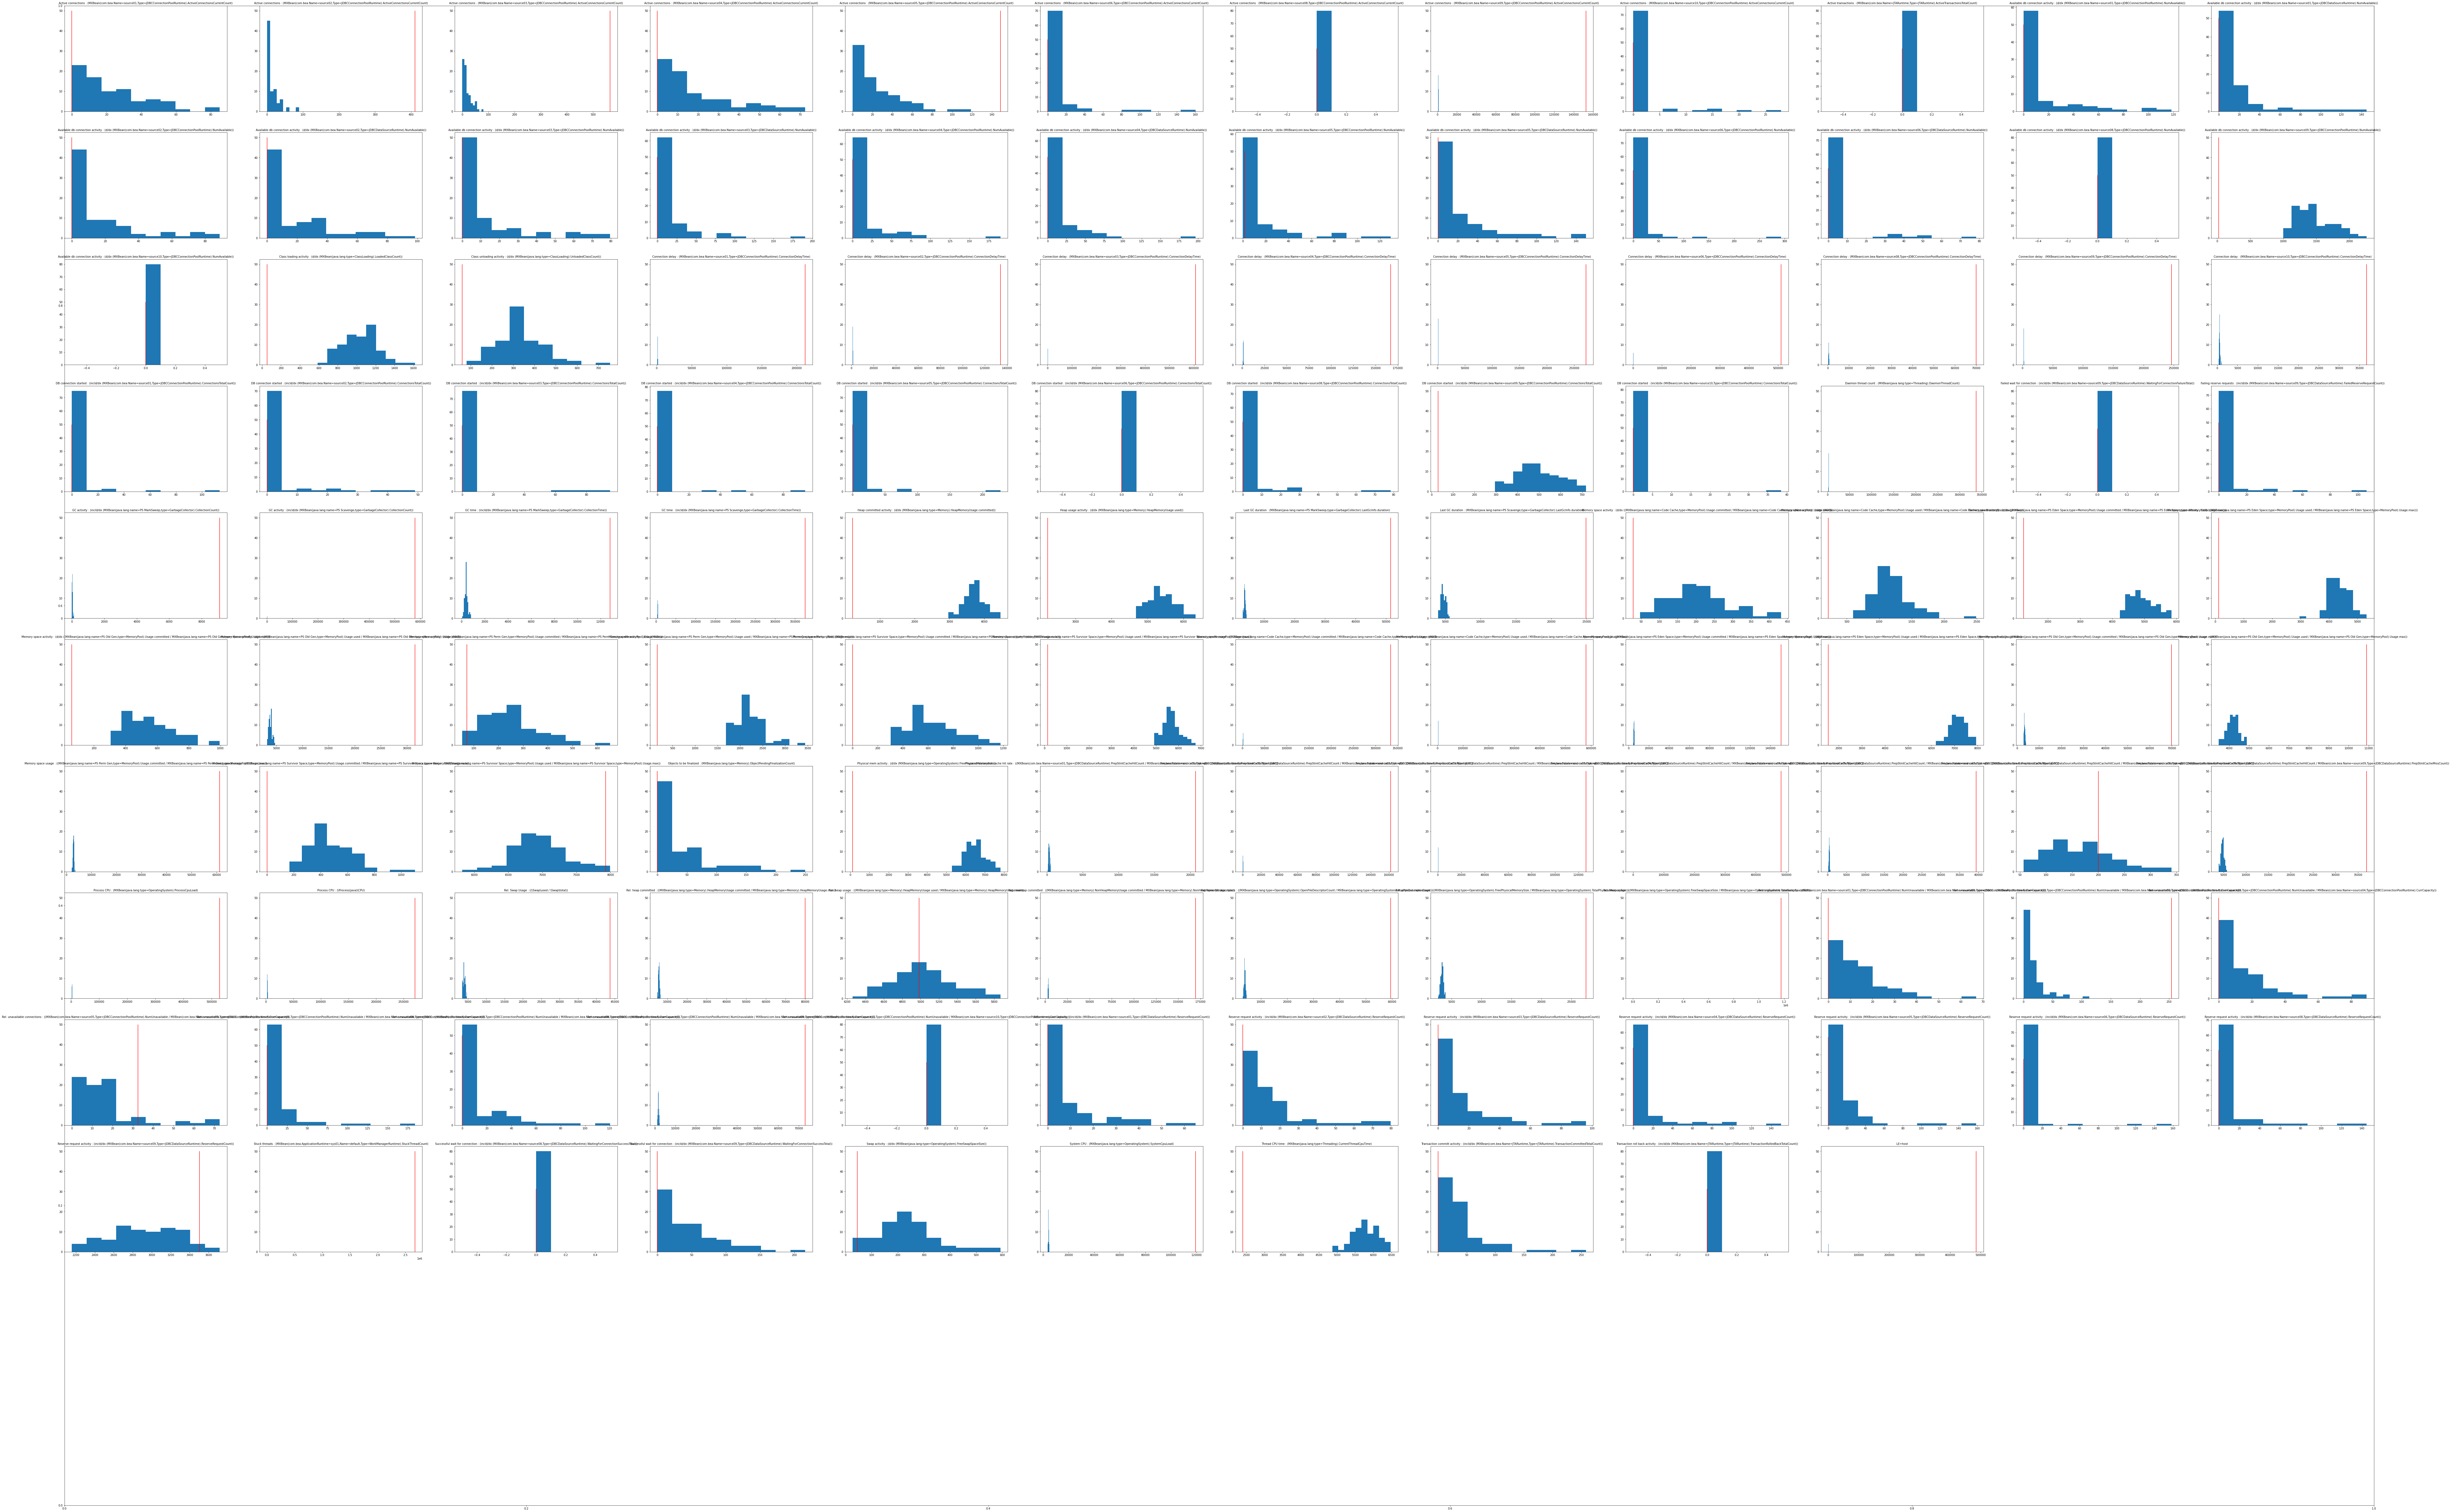

In [9]:
#ヒストグラムを表示し重要度と比較
fig, ax = plt.subplots(figsize=(150,100),tight_layout=False)

for x,y in zip(null_imp_df['feature'] , range(1,len(actual_imp_df['feature']))):
        feature_df = null_imp_df[null_imp_df['feature'] == x]
        ax = fig.add_subplot(12, 12, y) 
        ax.hist(feature_df['importance']) 
        ax.set_title(x,fontsize=10)
        actual_feat = actual_imp_df[actual_imp_df['feature'] == x]
        plt.vlines(actual_feat['importance'],0,50,'red')

In [10]:
#実際の特徴量重要度がnull_importamceよりも右側に来る特徴量を表示
feature_scores = []
for x in actual_imp_df['feature']:

        feature_df = null_imp_df[null_imp_df['feature'] == x]
        max=feature_df['importance'].max()
        actual_feat = actual_imp_df[actual_imp_df['feature'] == x].iat[0,1]
        imp_score = actual_feat/max
        feature_scores.append((x, imp_score))
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'imp_score'])
new_features=scores_df[scores_df['imp_score'] > 1].iloc[:,0].tolist()
print(new_features)
print(len(new_features))

['Active connections : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Connection delay : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Conne

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [11]:
#訓練データの特徴量選択
# new_features=['Active connections : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Connection delay : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source06,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Daemon thread count : (MXBean(java.lang:type=Threading).DaemonThreadCount)', 'GC activity : (incld/dx (MXBean(java.lang:name=PS MarkSweep,type=GarbageCollector).CollectionCount))', 'GC activity : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionCount))', 'GC time : (incld/dx (MXBean(java.lang:name=PS MarkSweep,type=GarbageCollector).CollectionTime))', 'GC time : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionTime))', 'Last GC duration : (MXBean(java.lang:name=PS MarkSweep,type=GarbageCollector).LastGcInfo.duration)', 'Last GC duration : (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).LastGcInfo.duration)', 'Memory space activity : (d/dx ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max)))', 'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))', 'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.used / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))', 'Memory space usage : ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max))', 'Memory space usage : ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max))', 'Memory space usage : ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max))', 'Memory space usage : ((MXBean(java.lang:name=PS Perm Gen,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Perm Gen,type=MemoryPool).Usage.max))', 'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))', 'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))', 'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))', 'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))', 'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))', 'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))', 'Process CPU : (MXBean(java.lang:type=OperatingSystem).ProcessCpuLoad)', 'Process CPU : (\\Process(java)\\CPU)', 'Rel. Swap Usage : ((\\Swap\\used / \\Swap\\total))', 'Rel. heap committed : ((MXBean(java.lang:type=Memory).HeapMemoryUsage.committed / MXBean(java.lang:type=Memory).HeapMemoryUsage.max))', 'Rel. nonHeap committed : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.committed / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max))', 'Rel. open file descriptors : ((MXBean(java.lang:type=OperatingSystem).OpenFileDescriptorCount / MXBean(java.lang:type=OperatingSystem).MaxFileDescriptorCount))', 'Rel. physical mem usage : ((MXBean(java.lang:type=OperatingSystem).FreePhysicalMemorySize / MXBean(java.lang:type=OperatingSystem).TotalPhysicalMemorySize))', 'Rel. swap usage : ((MXBean(java.lang:type=OperatingSystem).FreeSwapSpaceSize / MXBean(java.lang:type=OperatingSystem).TotalSwapSpaceSize))', 'Rel. unavailable connections : ((MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).CurrCapacity))', 'Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).CurrCapacity))', 'Stuck threads : (MXBean(com.bea:ApplicationRuntime=sys01,Name=default,Type=WorkManagerRuntime).StuckThreadCount)', 'System CPU : (MXBean(java.lang:type=OperatingSystem).SystemCpuLoad)', 'LE=host', 'LE=process']
train_df = train_df[new_features]

In [12]:
#選択された特徴量のカラムのみtest_dfに読み込む
import_features = new_features[0:47]
import_features[45:47] = 'host','process'
test_original = pd.read_csv('/content/drive/MyDrive/Nishika ソフトウェアの異常検知/test.zip (Unzipped Files)/test.csv',usecols = import_features)

In [13]:
#testデータのコピーを取る
test_df = test_original.copy()
# ラベルエンコーディング
cat_cols = ["host", "process"]
test_df = get_label_encoding(test_df, cat_cols)
# 不要なカラムの削除
test_df = test_df[new_features]

In [14]:
#optunaで算出したlightGBMのハイパーパラメータ
params = {'bagging_fraction': 0.5257969439659902,
 'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.5,
 'feature_pre_filter': False,
 'lambda_l1': 2.27205059672626e-05,
 'lambda_l2': 3.310432553564272e-07,
 'learning_rate': 0.01,
 'metric': 'binary_logloss',
 'min_child_samples': 20,
 'num_leaves': 31,
 'objective': 'binary',
 'task': 'train'}

In [15]:
#StratifiedKFoldによるvalidationでモデルの学習を行う

valid_scores = []
models = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for fold, (train_indices, valid_indices) in enumerate(kf.split(train_df, target)):
    X_train, X_valid = train_df.loc[train_indices], train_df.loc[valid_indices]
    y_train, y_valid = target[train_indices], target[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params=params, 
        train_set=lgb_train,
        valid_sets=lgb_eval,  
        early_stopping_rounds=20,
        num_boost_round=100000,
        verbose_eval = 100
        )
    
    y_valid_pred = model.predict(X_valid)
    score = log_loss(y_valid, y_valid_pred)
    print(f'fold {fold} log loss: {score}')
    valid_scores.append(score)

    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

Training until validation scores don't improve for 20 rounds.
[100]	valid_0's binary_logloss: 0.0210551
[200]	valid_0's binary_logloss: 0.00758038
[300]	valid_0's binary_logloss: 0.00296604
[400]	valid_0's binary_logloss: 0.00121518
[500]	valid_0's binary_logloss: 0.000535209
[600]	valid_0's binary_logloss: 0.000258687
[700]	valid_0's binary_logloss: 0.000142487
[800]	valid_0's binary_logloss: 9.07885e-05
[900]	valid_0's binary_logloss: 6.68824e-05
[1000]	valid_0's binary_logloss: 5.57423e-05
[1100]	valid_0's binary_logloss: 5.01458e-05
[1200]	valid_0's binary_logloss: 4.74842e-05
Early stopping, best iteration is:
[1237]	valid_0's binary_logloss: 4.68888e-05
fold 0 log loss: 4.688881861947467e-05
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's binary_logloss: 0.0210318
[200]	valid_0's binary_logloss: 0.00754107
[300]	valid_0's binary_logloss: 0.00293256
[400]	valid_0's binary_logloss: 0.00118459
[500]	valid_0's binary_logloss: 0.000510202
[600]	valid_0's 

In [16]:
#通常のクロスバリデーションでモデルの学習を行う
valid_scores = []
models = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for fold, (train_indices, valid_indices) in enumerate(kf.split(train_df)):
    X_train, X_valid = train_df.loc[train_indices], train_df.loc[valid_indices]
    y_train, y_valid = target[train_indices], target[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model2 = lgb.train(
        params=params, 
        train_set=lgb_train,
        valid_sets=lgb_eval,  
        early_stopping_rounds=20,
        num_boost_round = 100000,
        verbose_eval = 100
        )

    y_valid_pred = model2.predict(X_valid)
    score = log_loss(y_valid, y_valid_pred)
    print(f'fold {fold} log_loss: {score}')
    valid_scores.append(score)

    models.append(model2)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

Training until validation scores don't improve for 20 rounds.
[100]	valid_0's binary_logloss: 0.0211319
[200]	valid_0's binary_logloss: 0.00760175
[300]	valid_0's binary_logloss: 0.00297227
[400]	valid_0's binary_logloss: 0.00121475
[500]	valid_0's binary_logloss: 0.000536527
[600]	valid_0's binary_logloss: 0.000262831
[700]	valid_0's binary_logloss: 0.000148652
[800]	valid_0's binary_logloss: 0.000100408
[900]	valid_0's binary_logloss: 8.05171e-05
[1000]	valid_0's binary_logloss: 7.22493e-05
[1100]	valid_0's binary_logloss: 6.95286e-05
Early stopping, best iteration is:
[1127]	valid_0's binary_logloss: 6.91638e-05
fold 0 log_loss: 6.91638327746361e-05
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's binary_logloss: 0.021107
[200]	valid_0's binary_logloss: 0.00757624
[300]	valid_0's binary_logloss: 0.00296066
[400]	valid_0's binary_logloss: 0.00121559
[500]	valid_0's binary_logloss: 0.000546329
[600]	valid_0's binary_logloss: 0.000277839
[700]	valid_0's bin

In [17]:
# submissionの作成(StratifiedKFold)
submission_df = pd.read_csv('/content/drive/MyDrive/Nishika ソフトウェアの異常検知/data.zip (Unzipped Files)/sample_submission.csv')
id_df=submission_df.iloc[:,0]

pred = model.predict(test_df,num_iteration=model.best_iteration)
pred_df = pd.DataFrame(pred)

output_df=pd.concat([id_df, pred_df],axis=1)
output_df.columns=['id','Anomaly']
output_df.to_csv('/content/drive/MyDrive/Nishika ソフトウェアの異常検知/提出用ファイル/featureselected_lgb_tuned_StratifiedKFold.csv',index=False)

In [18]:
# submissionの作成(StratifiedKFoldとKfoldの平均)
pred2 = model2.predict(test_df,num_iteration=model.best_iteration)
pred2_df = pd.DataFrame(pred2)

pred2_df =(pred_df+pred2_df)/2

output_df=pd.concat([id_df, pred2_df],axis=1)
output_df.columns=['id','Anomaly']
output_df.to_csv('/content/drive/MyDrive/Nishika ソフトウェアの異常検知/提出用ファイル/featureselected_lgb_tuned_validmean.csv',index=False)